In [1]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# === 설정 ===
resolution = 50
cell_size = mp.Vector3(3, 3, 0)
fcen = 1.75       # Gaussian source 중심 주파수
df = 3.3          # Gaussian source 대역폭
nfreq = 300

field_component = mp.Ex  # 원하는 필드 성분

# === 측정할 파장 범위 (0.4 ~ 0.7 μm) ⇒ 주파수로 변환 ===
lambda_min = 0.4
lambda_max = 0.7
fmin = 1 / lambda_max   # ≈ 1.4286
fmax = 1 / lambda_min   # = 2.5
fcen_dft = 0.5 * (fmin + fmax)
df_dft = fmax - fmin

source_center = mp.Vector3(0, 0)

sources = [mp.Source(
    src = mp.GaussianSource(frequency = fcen, fwidth = df),
    center = mp.Vector3(0,0,0),
    component=mp.Ex
)]

In [3]:
pml_layer = 0.5

pml_boundary = [mp.PML(thickness=pml_layer)]

# === 시뮬레이션 설정 === #
sim_air = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=pml_boundary,
    default_material=mp.Medium(index=1),
    sources=sources,
    resolution=resolution,
)

<Axes: xlabel='X', ylabel='Y'>

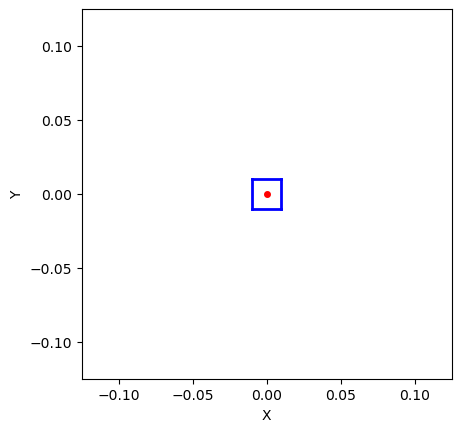

In [ ]:
offset = 0.01
flux_size = 0.02

field_component = mp.Ex

# === x1 (왼쪽 세로 라인) ===
box_x1 = sim_air.add_flux(
    fcen_dft, df_dft, nfreq,
    mp.FluxRegion(center=source_center - mp.Vector3(offset, 0), size=mp.Vector3(0, flux_size),  direction = mp.Ex), 
)

# === x2 (왼쪽 세로 라인) ===
box_x2 = sim_air.add_flux(
    fcen_dft, df_dft, nfreq,
    mp.FluxRegion(center=source_center + mp.Vector3(offset, 0), size=mp.Vector3(0, flux_size), direction=mp.Ex),  
)

# === y1 (왼쪽 세로 라인) ===
box_y1 = sim_air.add_flux(
    fcen_dft, df_dft, nfreq,
    mp.FluxRegion(center=source_center - mp.Vector3(0, offset), size=mp.Vector3(flux_size, 0), direction = mp.Ey), 
)

# === y2 (왼쪽 세로 라인) ===
box_y2 = sim_air.add_flux(
    fcen_dft, df_dft, nfreq,
    mp.FluxRegion(center=source_center + mp.Vector3(0, offset), size=mp.Vector3(flux_size, 0), direction =mp.Ey), 
)

sim_air.plot2D(output_plane=mp.Volume(center = mp.Vector3(0,0,0), size = mp.Vector3(0.25, 0.25)))

In [200]:
sim_air.run(until = 200)

on time step 5000 (time=50), 1.93254 s/step
run 1 finished at t = 250.0 (25000 timesteps)


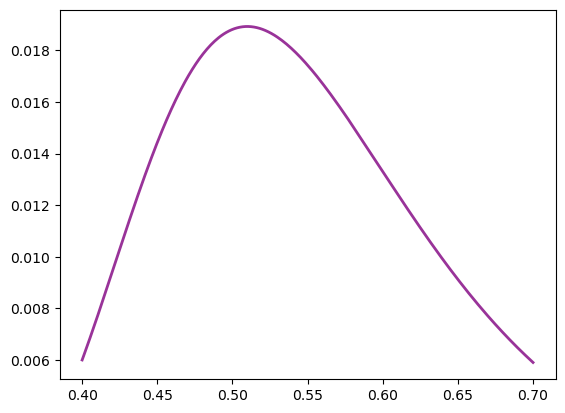

In [201]:
# === 데이터 추출 및 파장 변환 ===
x1_air = np.array(mp.get_fluxes(box_x1))              # power [W] at each frequency
x2_air = np.array(mp.get_fluxes(box_x2))              # power [W] at each frequency
y1_air = np.array(mp.get_fluxes(box_y1))              # power [W] at each frequency
y2_air = np.array(mp.get_fluxes(box_y2))              # power [W] at each frequency

frequencies = np.array(mp.get_flux_freqs(box_x1))    # frequency [1/μm]

wavelengths = 1 / frequencies   

box = -x1_air+x2_air-y1_air+y2_air

# plt.plot(wavelengths, x1_air, linewidth=2, color='red', alpha=0.8)
# plt.plot(wavelengths, x2_air, linewidth=2, color='dodgerblue', alpha=0.8)
# plt.plot(wavelengths, y1_air, linewidth=2, color='blue', alpha=0.8)
# plt.plot(wavelengths, y2_air, linewidth=2, color='green', alpha=0.8)
plt.plot(wavelengths, box, linewidth=2, color='purple', alpha=0.8)
# plt.ylim(-1e-14,1e-14)

In [52]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
import nlopt
from meep_material import lorentzfit

def Material_fit(Material_data_csv=".", 
                   eps_inf=1,
                   fit_wl_min=0.38, fit_wl_max=0.72,
                   num_lorentzians=2, iteration=30
                   ):    

    # 1. 데이터 로드 및 전처리
    data = np.genfromtxt(Material_data_csv, delimiter=",")
    wl = data[:, 0] * 1e6  # 파장 (µm)
    n_data = data[:, 1] + 1j * data[:, 2]
    eps_all = np.square(n_data) - eps_inf

    # 피팅 범위로 데이터 선택
    mask = (wl >= fit_wl_min) & (wl <= fit_wl_max)
    wl_fit, eps_fit = wl[mask], eps_all[mask]
    freqs_fit = 1 / wl_fit

    # 2. Lorentzian 피팅 최적화
    ps = np.zeros((iteration, 3 * num_lorentzians))
    errors = np.zeros(iteration)
    for m in range(iteration):
        p_rand = [10 ** np.random.random() for _ in range(3 * num_lorentzians)]
        ps[m, :], errors[m] = lorentzfit(p_rand, freqs_fit, eps_fit, nlopt.LD_MMA, 1e-25, 50000)
        print(f"Iteration {m:3d}, error: {errors[m]:.6f}")
    best = np.argmin(errors)
    print(f"Optimal error: {errors[best]:.6f}")

    # 3. 최적 파라미터로 Susceptibility 생성 및 Meep 모델 구성
    suscept = []
    for i in range(num_lorentzians):
        freq_param = ps[best][3*i + 1]
        gamma = ps[best][3*i + 2]
        if freq_param == 0:
            sigma = ps[best][3*i + 0]
            suscept.append(mp.DrudeSusceptibility(frequency=1.0, gamma=gamma, sigma=sigma))
        else:
            sigma = ps[best][3*i + 0] / freq_param**2
            suscept.append(mp.LorentzianSusceptibility(frequency=freq_param, gamma=gamma, sigma=sigma))

    return eps_inf, suscept

sio2_data_path = "/home/min/EIDL/Tool/Meep/LGD/Material CSV/Al_Palik/Data/CSV file/SiO2/CSV/SiO2_palik_data.csv"

eps_inf_sio2, suscept_sio2 = Material_fit(Material_data_csv=sio2_data_path)


Iteration   0, error: 0.000025
Iteration   1, error: 0.000016
Iteration   2, error: 0.000026
Iteration   3, error: 0.000009
Iteration   4, error: 0.000016
Iteration   5, error: 0.000189
Iteration   6, error: 0.000014
Iteration   7, error: 0.000009
Iteration   8, error: 0.000011
Iteration   9, error: 0.000014
Iteration  10, error: 0.000077
Iteration  11, error: 0.000013
Iteration  12, error: 0.000005
Iteration  13, error: 0.000043
Iteration  14, error: 0.000052
Iteration  15, error: 0.000006
Iteration  16, error: 0.000006
Iteration  17, error: 0.000023
Iteration  18, error: 0.000017
Iteration  19, error: 0.000013
Iteration  20, error: 0.000032
Iteration  21, error: 0.000008
Iteration  22, error: 0.000022
Iteration  23, error: 0.000013
Iteration  24, error: 0.000050
Iteration  25, error: 0.000029
Iteration  26, error: 0.000025
Iteration  27, error: 0.000145
Iteration  28, error: 0.000009
Iteration  29, error: 0.000045
Optimal error: 0.000005


In [53]:
SiO2 = mp.Medium(epsilon=eps_inf_sio2, E_susceptibilities = suscept_sio2) # SiO2 

In [204]:
geometry = [
    # Cathode (하단)
    mp.Block(
        center=mp.Vector3(0, 1.625, 0),
        size=mp.Vector3(mp.inf, 2.75, 0),
        material=mp.Medium(index = 1)
    ),
    # Alq3
    mp.Block(
        center=mp.Vector3(0,0,0),
        size=mp.Vector3(mp.inf, 0.5, 0),
        material=mp.Medium(index = 1.68)
    ),
    # Glass (상단; (0,0,0)은 이 Glass 내부에 위치함)
    mp.Block(
        center=mp.Vector3(0, -1.625, 0),
        size=mp.Vector3(mp.inf, 2.75, 0),
        material=SiO2
    )
]

-----------
Initializing structure...
time for choose_chunkdivision = 0.000133038 s
Working in 2D dimensions.
Computational cell is 3 x 3 x 0 with resolution 50
     block, center = (0,1.625,0)
          size (1e+20,2.75,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,0,0)
          size (1e+20,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.8224,2.8224,2.8224)
     block, center = (0,-1.625,0)
          size (1e+20,2.75,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0275509 s
lorentzian susceptibility: frequency=10.2978, gamma=0
lorentzian susceptibility: frequency=10.577, gamma=0
-----------
Meep progress: 169.24/200.0 = 84.6% done in 4.6s, 0.8s to go
on time step 16924 (time=169.24), 0.000269308 s/step
run 0 finished at t = 200.0 (20000 timesteps)


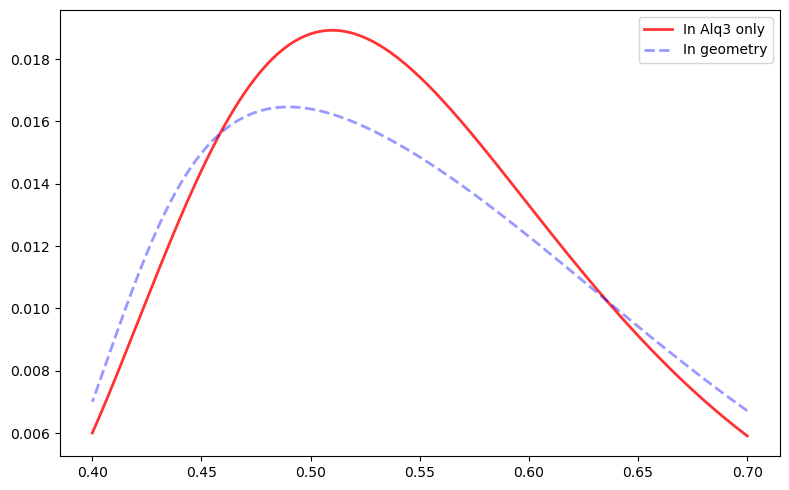

In [214]:
offset = 0.01
flux_size = 0.02


sim_SiO2 = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=pml_boundary,
    geometry=geometry,
    # default_material=mp.Medium(index = 1.68),
    sources=sources,
    resolution=resolution,
)

# === x1 (왼쪽 세로 라인) ===
box_x1_2 = sim_SiO2.add_flux(
    fcen_dft, df_dft, nfreq,
    mp.FluxRegion(center=source_center - mp.Vector3(offset, 0), size=mp.Vector3(0, flux_size),  ), 
)

# === x2 (왼쪽 세로 라인) ===
box_x2_2 = sim_SiO2.add_flux(
    fcen_dft, df_dft, nfreq,
    mp.FluxRegion(center=source_center + mp.Vector3(offset, 0), size=mp.Vector3(0, flux_size), ),  
)

# === y1 (왼쪽 세로 라인) ===
box_y1_2 = sim_SiO2.add_flux(
    fcen_dft, df_dft, nfreq,
    mp.FluxRegion(center=source_center - mp.Vector3(0, offset), size=mp.Vector3(flux_size, 0), ), 
)

# === y2 (왼쪽 세로 라인) ===
box_y2_2 = sim_SiO2.add_flux(
    fcen_dft, df_dft, nfreq,
    mp.FluxRegion(center=source_center + mp.Vector3(0, offset), size=mp.Vector3(flux_size, 0), ), 
)

sim_SiO2.run(until = 200)

# === 데이터 추출 및 파장 변환 ===
x1_air_2 = np.array(mp.get_fluxes(box_x1_2))              # power [W] at each frequency
x2_air_2 = np.array(mp.get_fluxes(box_x2_2))              # power [W] at each frequency
y1_air_2 = np.array(mp.get_fluxes(box_y1_2))              # power [W] at each frequency
y2_air_2 = np.array(mp.get_fluxes(box_y2_2))              # power [W] at each frequency

frequencies = np.array(mp.get_flux_freqs(box_x1))    # frequency [1/μm]

wavelengths = 1 / frequencies   

box = -x1_air+x2_air-y1_air+y2_air
box_2 = -x1_air_2+x2_air_2-y1_air_2+y2_air_2

norm = box / box_2
plt.figure(figsize=(8, 5))

# 비교용 데이터 (_2는 보통 후처리나 다른 조건 결과일 가능성 있음)
plt.plot(wavelengths, box, linewidth=2, color='red', alpha=0.8, label='In Alq3 only')
plt.plot(wavelengths, box_2, linewidth=2, color='blue', alpha=0.4, linestyle='--', label='In geometry')
# plt.plot(wavelengths,norm, linewidth=2, color='blue', alpha=0.4, linestyle='--', label='Index = SiO2')
# 필요하면 나머지도 추가해서 비교 가능
# plt.plot(wavelengths, x2_air_2, linewidth=2, color='dodgerblue', alpha=0.8, label='x2_air_2')
# plt.plot(wavelengths, x2_air, linewidth=2, color='dodgerblue', alpha=0.4, linestyle='--', label='x2_air')

# plt.xlabel("Wavelength")
# plt.ylabel("Transmission")
# plt.title("Comparison of air vs Different index")
plt.legend()
# plt.grid(True)
plt.tight_layout()
plt.show()

     block, center = (0,1.625,0)
          size (1e+20,2.75,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,0,0)
          size (1e+20,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.8224,2.8224,2.8224)
     block, center = (0,-1.625,0)
          size (1e+20,2.75,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)


<Axes: xlabel='X', ylabel='Y'>

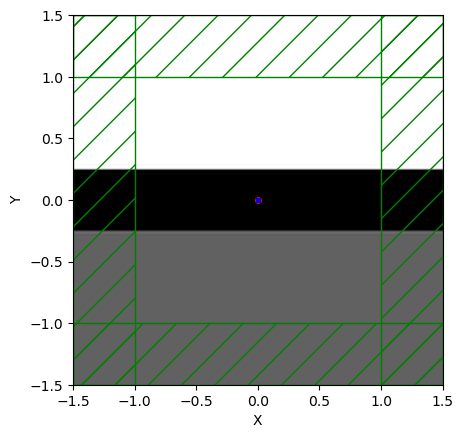

In [213]:
sim_SiO2.plot2D()

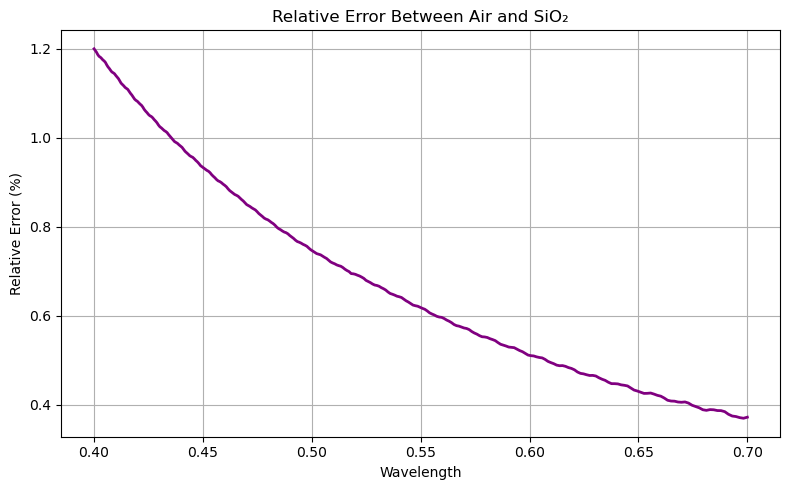

In [ ]:
# === 오차율 계산 ===
# 작은 수로 나눠지는 걸 방지하기 위해 box가 0인 부분은 아주 작은 값으로 교체
box_safe = np.where(np.abs(box) < 1e-10, 1e-10, box)

# 상대 오차율 (%) 계산
error_rate = np.abs((box_2 - box) / box_safe) * 100  # [%]

# === 오차율 시각화 ===
plt.figure(figsize=(8, 5))
plt.plot(wavelengths, error_rate, color='purple', linewidth=2)
plt.xlabel("Wavelength")
plt.ylabel("Relative Error (%)")
plt.title("Relative Error Between Air and SiO₂")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import tidy3d as td